## Hyperbolic Word Embedding Demo 

This is a demo of hyperbolic word embedding using hyerlib, following Nickel & Kiela, "_Poincaré Embeddings for Learning Hierarchical Representations_."

One can make words (nouns) into a graph via the hypernym relation. **A** is a hypernym of **B** if "**B** is an **A**."  In that case there is an edge **B** &rarr; **A**. For example "composer" is a hypernym of "Bach." A hierarchical relation like this gives rise to a hidden (approximate) tree structure (see e.g. Krioukov et al, "_Hyperbolic Geometry of Complex Networks_"). 

Since hyperbolic space is ideal for embedding tree-like graphs, we expect hyperbolic word embeddings to capture semantic relationships like hyper/hyponymy better than Euclidean ones, and in lower dimensions.  We will embed a subtree of [WordNet](https://wordnet.princeton.edu/) in 2-dimensional hyperbolic space.

In [1]:
import sys
sys.path.insert(1, '..') #if hyperlib not installed
from collections import defaultdict
import warnings
import hyperlib.utils.math as hmath #hyperbolic functions
from hyperlib.nn.optimizers.rsgd import RSGD
import tensorflow as tf
import numpy as np
from matplotlib.collections import LineCollection
import matplotlib.pyplot as plt 

# Get wordnet from nltk 
from nltk.corpus import wordnet
import nltk
nltk.download("wordnet") 

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/meiji163/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
def stem(syn):
    return syn.split('.')[0]

def subtree_closure(name):
    """ Transitive closure of the WordNet subtree rooted at `name`
    Args:
        name: root word in wordnet notation, e.g `mammal.n.01`
        
    Returns: dict with the following keys
        id: dict mapping words to int labels
        word: dict mapping int label to word
        adj: dict mapping int label to set of transitive hyponyms
        tree: adjacency list for non-trasitive hyponym graph
    """
    warnings.filterwarnings('ignore', '.*Discarded')  # ignore nltk warnings
    hypo = lambda s: s.hyponyms()
    get_idx = lambda s: to_idx[s.name()]
    root = wordnet.synset(name)
    to_idx = { syn.name(): i+1
              for i, syn in enumerate(root.closure(hypo))}
    to_idx[name] = 0
    to_word = { i:w for w,i in to_idx.items()}
    vocab_size = max(to_word.keys())
    adj = defaultdict(set)
    tree = defaultdict(set)
    queue = [root]
    while queue:
        syn = queue.pop(0)
        i = get_idx(syn)
        hypos = list(map(get_idx, syn.closure(hypo)))
        if hypos:
            for j in hypos:
                adj[j].add(i)
        queue.extend(syn.hyponyms())
        tree[i] = tree[i].union(map(get_idx,syn.hyponyms()))
    
    return {"adj": adj,
            "ids":to_idx,
            "tree": tree,
            "words": to_word}

In [3]:
# -------- Process the hypernym graph ---------
# I use the "fungus" subtree but you can change this

graph = subtree_closure("fungus.n.01") 
vocab_size = max(graph["words"])+1
adj = graph["adj"]
all_ids = set(range(vocab_size))
dual = {i: list(all_ids.difference(adj[i])) # adjacency list of the dual graph
            for i in range(vocab_size)} 

edges = np.array([ [i,j] for i in adj for j in adj[i] ])
idxs = np.array([e[0] for e in edges])
edge_dataset = tf.data.Dataset.from_tensor_slices(edges)
dataset_size = len(edges)

print(f"vocab size: {vocab_size}")
print(f"dataset size: {dataset_size}")

vocab size: 309
dataset size: 726


### Model & Training

The Poincaré disc model with curvature \$-c\$ is the set \$\\{(x,y) \in \mathbb{R}^2, x^2+y^2 < \frac{1}{c}\\}\$. I embed the graph with c=16, but you can tune this hyperparameter (ideally it's chosen based on the degree distribution of the graph).

For each edge \$ (u,v) \in E\$ (i.e. hypernym relation) in the graph, the loss of the embedding is
\$\$ \log \dfrac{ e^{-d(u,v)} }{ \sum_{(u,v')\notin E}e^{-d(u,v')}}, \$\$
where \$E\$ is the set of edges and \$ d(u,v) \$ is the hyperbolic length of the embedded edge. For optimization we use Riemannian SGD.

In [4]:
def neg_sample(idx, n_neg=18):
    i = idx.numpy().item()
    end = np.random.choice(dual[i],n_neg)
    beg = np.broadcast_to([idx], (n_neg,))  
    return np.stack([beg,end], axis=1)

def link_loss(embedding, edges, c=1.0):
    """ The loss function defined in Nickel & Kiela. 
    Does negative sampling to approximate the denominator
    Args:
        embedding: tensorflow Embedding layer
        edges: batch of edges 
        c: The (negative) curvature
    """
    e = embedding(edges)
    negs = tf.map_fn(neg_sample,edges[:,0])
    negs = embedding(negs)
    #calculate pairwise hyperbolic lengths of embedded edges
    neg_dist = hmath.hyp_dist(negs[:,:,0],negs[:,:,1],c)
    pos_dist = hmath.hyp_dist(e[:,0],e[:,1],c)
    denom = tf.reduce_sum( tf.exp(-neg_dist), axis=1)
    return tf.reduce_sum(tf.add(pos_dist,denom))

def training_loop(model, n_itrs, lr=0.005, c=1.0):
    losses = []
    opt = RSGD(learning_rate=lr, curvature=c)
    for _ in range(n_itrs):
        bs = 16
        for i, edges in enumerate(edge_dataset.shuffle(1000).batch(bs)):
            with tf.GradientTape() as tape:
                loss = link_loss(model,edges,c)
            grads = tape.gradient(loss, model.trainable_variables)
            opt.apply_gradients(zip(grads, model.trainable_variables))
            losses.append(loss/bs)
    return tf.reduce_mean(losses)

def train(model, epochs, n_itrs=50, lr=0.005, c=1.0):
    for e in range(epochs):
        loss = training_loop(model, n_itrs, lr, c)
        print(f"epoch: {e} --------- loss: {loss:.3f}")

In [5]:
# Define embedding and initialize close to the origin
tf.random.set_seed(163)
embed_init = tf.keras.initializers.RandomUniform(minval=-0.001, maxval=0.001) 
hyp_embedding = tf.keras.layers.Embedding(vocab_size, 2,
                                    embeddings_initializer=embed_init)
curv = 16.0
train(hyp_embedding, epochs=10, lr=1e-4, c=curv)
train(hyp_embedding, epochs=10, lr=1e-3, c=curv)

epoch: 0 --------- loss: 15.214
epoch: 1 --------- loss: 11.637
epoch: 2 --------- loss: 9.355
epoch: 3 --------- loss: 7.886
epoch: 4 --------- loss: 7.020
epoch: 5 --------- loss: 6.509
epoch: 6 --------- loss: 6.193
epoch: 7 --------- loss: 5.980
epoch: 8 --------- loss: 5.832
epoch: 9 --------- loss: 5.731
epoch: 0 --------- loss: 5.497
epoch: 1 --------- loss: 5.358
epoch: 2 --------- loss: 5.320
epoch: 3 --------- loss: 5.301
epoch: 4 --------- loss: 5.287
epoch: 5 --------- loss: 5.275
epoch: 6 --------- loss: 5.266
epoch: 7 --------- loss: 5.262
epoch: 8 --------- loss: 5.256
epoch: 9 --------- loss: 5.250


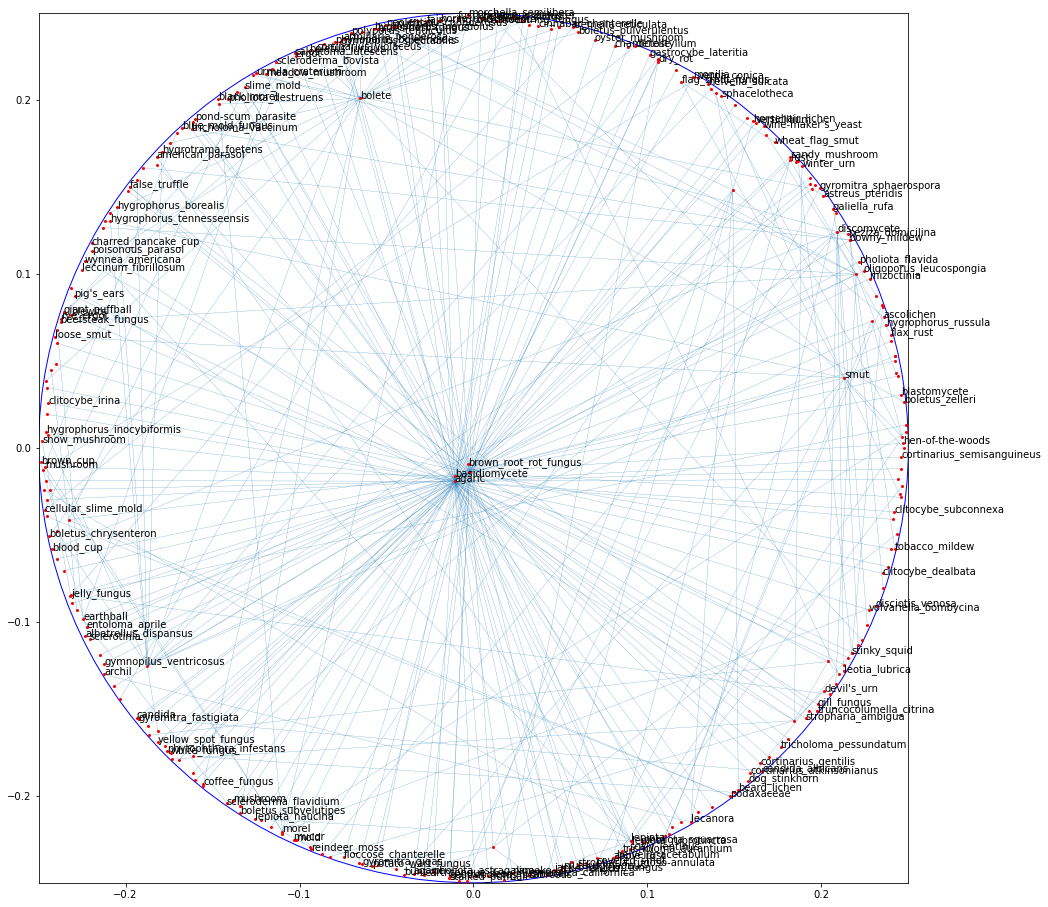

In [6]:
def plot_edges(embedding, edges, ids, c=1.0):
    """Plot the embedding and show labels"""
    lines = embedding(edges).numpy()
    lc = LineCollection(lines,linewidths=0.2)
    r = 1/c**0.5
    plt.figure(figsize=(16, 16))
    circle = plt.Circle((0, 0), r, fill=False, color="b")
    plt.gca().add_collection(lc)
    plt.gca().add_artist(circle)
    plt.xlim(-r, r)
    plt.ylim(-r, r)
    plt.gca().set_aspect("equal")
    pts = embedding(tf.range(vocab_size)).numpy()
    for i in ids:
        plt.annotate(
            stem(graph["words"][i]),
            pts[i])
            #bbox=dict(facecolor='grey',alpha=0.1))
    plt.scatter(pts[:,0],pts[:,1], color='r',s=4.0, zorder=2)

tree = graph["tree"]
ids = sorted(graph["words"], key=lambda s: -len(tree[s]))[::2] #change this for more/less labels
edges = np.array([[i,j] for i in adj for j in tree[i]])
plot_edges(hyp_embedding, edges, ids, curv)

In [7]:
def reconstruct_loss(embedding, c=1.0):
    """Rank the distance of each embedded edge 
    in the set of negative examples (non-edges).
    The mean rank is the recostruction loss."""
    ranks = []
    for i in adj: 
        negs = tf.constant(dual[i])
        beg = tf.broadcast_to([i], negs.shape)
        edges = hyp_embedding(tf.stack([beg,negs], axis=1))
        dists = tf.sort(
                hmath.hyp_dist(edges[:,:,0],edges[:,:,1], c),
                axis=0)
        for j in adj[i]:
            pos_dist = hmath.hyp_dist(
                            hyp_embedding(i),hyp_embedding(j), c)
            rank = 0
            while(dists[rank] < pos_dist):
                rank += 1
            ranks.append(rank)
    return ranks

ranks = reconstruct_loss(hyp_embedding, curv)
mean_rank = sum(ranks)/len(ranks)
print(f"reconstruction loss --------- {mean_rank:.2f}")

reconstruction loss --------- 3.72
